In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

df = pd.read_csv("../../data/results.csv")
df.head()

,id,original,file,av,category,result
0,0,less,/home/alex/Projects/MKPKResults/bin/less/less_...,Bkav,undetected,None
1,1,less,/home/alex/Projects/MKPKResults/bin/less/less_...,Lionic,undetected,None
2,2,less,/home/alex/Projects/MKPKResults/bin/less/less_...,Elastic,undetected,None
3,3,less,/home/alex/Projects/MKPKResults/bin/less/less_...,MicroWorld-eScan,undetected,None
4,4,less,/home/alex/Projects/MKPKResults/bin/less/less_...,CMC,undetected,None


In [163]:
def add_malware_type(df):
    new_df = df

    def extract_name(filename):
        if "_original" in filename:
            return "Original"
        elif "_reverse_tcp" in filename:
            return "Reverse TCP"
        elif "_egress_pswd" in filename:
            return "Egress Password"
        elif "_encrypt" in filename:
            return "Encrypt"
        else:
            return "Unknown"

    types = []
    for _, row in df.iterrows():
        types.append(extract_name(row['file']))

    new_df['malware_type'] = types
    return new_df


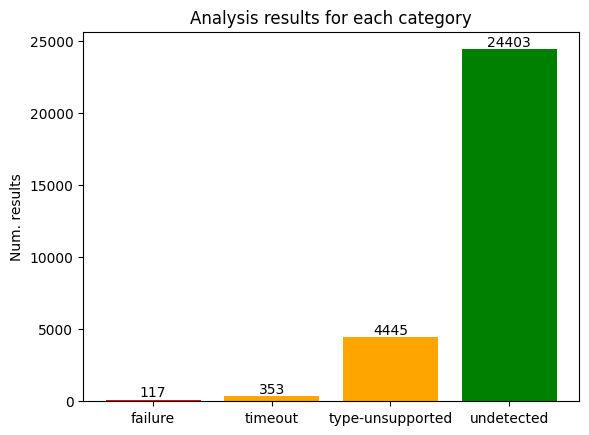

In [58]:

data = df.groupby("category").count()

labels = []
values = []
for group in df.groupby("category").groups.keys():
    labels.append(group)
    values.append(data.loc[group]['id'])

colours = ["red", "orange", "orange", "green"]

fig, ax = plt.subplots()

bc = ax.bar(labels, values, color=colours)
ax.bar_label(bc)

ax.set_ylabel("Num. results")
ax.set_title("Analysis results for each category")

plt.show()


/tmp/ipykernel_814/3208291038.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['malware_type'] = types


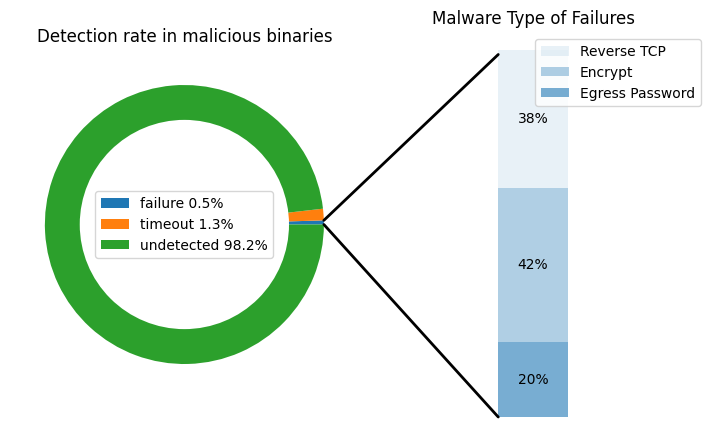

In [204]:
import numpy as np
from matplotlib.patches import ConnectionPatch

no_originals = df[~df['file'].str.contains("_original")]
malware_only = no_originals.groupby(['category']).size()
malware_only.drop(labels=["type-unsupported"], inplace=True)

malware_types = add_malware_type(no_originals)
failures_only = malware_types[malware_types['category'] == 'failure']
malware_type_count = failures_only.groupby(['malware_type']).size()
total_failures = sum(list(malware_type_count.values))


# Start plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5))
fig.subplots_adjust(wspace=0)

# Start pie chart
total_results = sum(list(malware_only.values))
labels = [f'{y} {np.round((x/total_results)*100, 1)}%' for x, y in zip(list(malware_only.values), ['failure', 'timeout', 'undetected'])]
wedges, *_ = ax1.pie(list(malware_only.values))
ax1.legend(labels=labels, loc="center")
circle = plt.Circle(xy=(0,0), radius=0.75, facecolor='white')
ax1.add_artist(circle)
ax1.set_title("Detection rate in malicious binaries")

# Start bar chart
bottom = 1
width = 0.2

# Add the bar chart
zipped_values = zip(list(malware_type_count.values), list(malware_type_count.index))
for j, (count, label) in enumerate(reversed([*zipped_values])):
    bottom -= count 
    bc = ax2.bar(0, count, width, bottom=bottom, color='C0', label=label, alpha=0.1 + 0.25*j)
    ax2.bar_label(bc, labels=[f"{count/total_failures:.0%}"], label_type='center')

ax2.set_title("Malware Type of Failures")
ax2.legend()
ax2.axis('off')
ax2.set_xlim(-2.5 * width, 2.5 * width)

# Draw lines between the plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = -sum(list(malware_type_count.values)) + 1

x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)


plt.show()

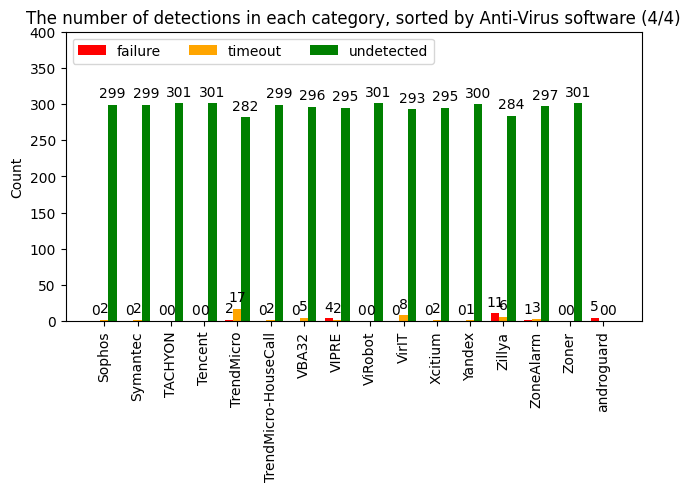

In [76]:
import numpy as np
import math

no_originals = df[~df['file'].str.contains("_original")]
avs_only = no_originals[['av', 'category']]
group_avs = avs_only.groupby(['av', 'category']).size()
av_data = group_avs.unstack().reset_index().rename_axis(None, axis=1)

width = 0.2
multiplier = 0
headings = ['failure', 'timeout', 'undetected']
colours = {'failure': 'red', 'timeout': 'orange', 'undetected': 'green'}
xtick_pos = []
av_names = []

fig, ax = plt.subplots(layout='constrained')
start = 48
count = 0
size = 15

for index, av in av_data.iterrows():
    if not math.isnan(av['type-unsupported']):
        continue

    if count < start:
        count += 1
        continue

    av_names.append(av.values[0])

    for head in headings:
        value = av[head]
        value = 0 if math.isnan(value) else value

        offset = width * multiplier
        rects = ax.bar(offset, value, width, label=head, color=colours[head])
        ax.bar_label(rects, padding=3)
        multiplier += 1
        
    xtick_pos.append(width*(multiplier-2))
    multiplier += 1
    count += 1

    if count > start + size:
        break


ax.set_ylabel("Count")
ax.set_title("The number of detections in each category, sorted by Anti-Virus software (4/4)")
ax.set_xticks(xtick_pos, av_names, rotation=90)
ax.legend(headings, loc='upper left', ncols=4)
ax.set_ylim(0, 400)
plt.show()



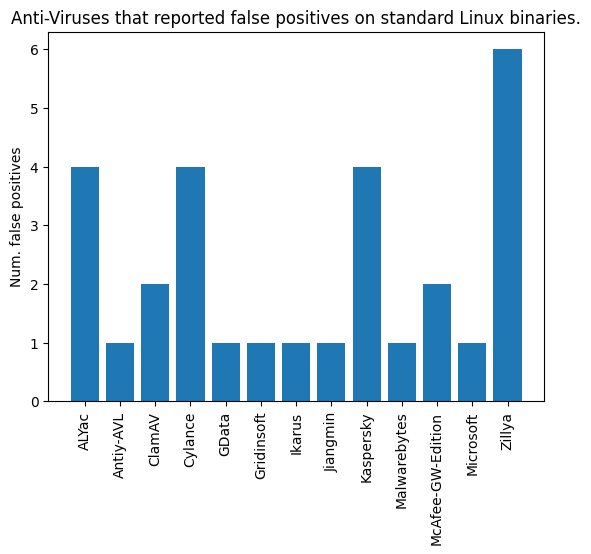

In [98]:
import math

only_originals = df[df['file'].str.contains("_original")]
avs_only = only_originals[['av', 'category']]
group_avs = avs_only.groupby(['av', 'category']).size()
av_data = group_avs.unstack().reset_index().rename_axis(None, axis=1)

av_names = []
av_values = []

for index, av in av_data.iterrows():
    if math.isnan(av['failure']):
        continue

    av_names.append(av.values[0])
    av_values.append(av['failure'])

fig, ax = plt.subplots()

ax.bar(av_names, av_values)
ax.set_xticks(np.arange(len(av_names)), labels=av_names, rotation=90)
ax.set_ylabel("Num. false positives")
ax.set_title("Anti-Viruses that reported false positives on standard Linux binaries.")

plt.show()


    

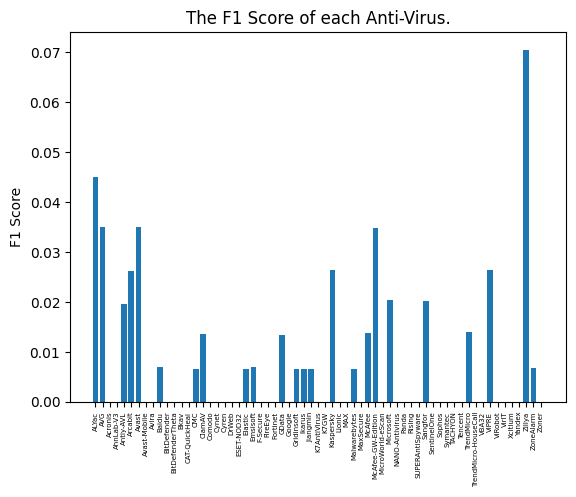

In [120]:
only_originals = df[df['file'].str.contains("_original")]
avs_only_orig = only_originals[['av', 'category']]
group_avs_orig = avs_only_orig.groupby(['av', 'category']).size()
av_data_orig = group_avs_orig.unstack().reset_index().rename_axis(None, axis=1)

no_originals = df[~df['file'].str.contains("_original")]
avs_only_no_orig = no_originals[['av', 'category']]
group_avs_no_orig = avs_only_no_orig.groupby(['av', 'category']).size()
av_data_no_orig = group_avs_no_orig.unstack().reset_index().rename_axis(None, axis=1)

av_names = []
av_values = []

av_df = pd.DataFrame(columns=["AV", "FP", "FN", "TP", "TN"])

# Add the rows with empty values.
for index, av in av_data_no_orig.iterrows():
    if math.isnan(av['type-unsupported']):
        av_df.loc[index] = [av.values[0]] + [0] * 4

av_df.set_index("AV", inplace=True)

# Add the original binary results.
for index, av in av_data_orig.iterrows():
    if math.isnan(av['type-unsupported']):
        av_df.loc[av.values[0]]['FP'] = av['failure']
        av_df.loc[av.values[0]]['TN'] = av['undetected']

# Add the injected binary results.
for index, av in av_data_no_orig.iterrows():
    if math.isnan(av['type-unsupported']):
        av_df.loc[av.values[0]]['TP'] = av['failure']
        av_df.loc[av.values[0]]['FN'] = av['undetected']

av_df['Precision'] = av_df["TP"] / (av_df["TP"] + av_df["FP"])
av_df['Precision'].fillna(0, inplace=True)
av_df['Recall'] = av_df["TP"] / (av_df["TP"] + av_df["FN"])
av_df['Recall'].fillna(0, inplace=True)
av_df['F1 Score'] = (2 * av_df['Precision'] * av_df['Recall']) / (av_df['Precision'] + av_df['Recall'])
av_df['F1 Score'].fillna(0, inplace=True)
av_df.drop(labels=['androguard'], inplace=True)

fig, ax = plt.subplots()

ax.bar(av_df.index, av_df['F1 Score'])
ax.set_xticks(np.arange(len(av_df.index)), av_df.index, rotation=90, fontsize=5)
ax.set_ylabel("F1 Score")
ax.set_title("The F1 Score of each Anti-Virus.")

plt.show()

In [121]:
avs_only = df[['av', 'category']]
group_avs = avs_only.groupby(['av', 'category']).size()
av_data = group_avs.unstack().reset_index().rename_axis(None, axis=1)

for index, av in av_data.iterrows():
    if not math.isnan(av['type-unsupported']):
        print(av.values[0]) 

APEX
Alibaba
Avast-Mobile
BitDefenderFalx
CrowdStrike
Cylance
Elastic
Paloalto
SentinelOne
SymantecMobileInsight
Trapmine
Trustlook
Webroot
tehtris


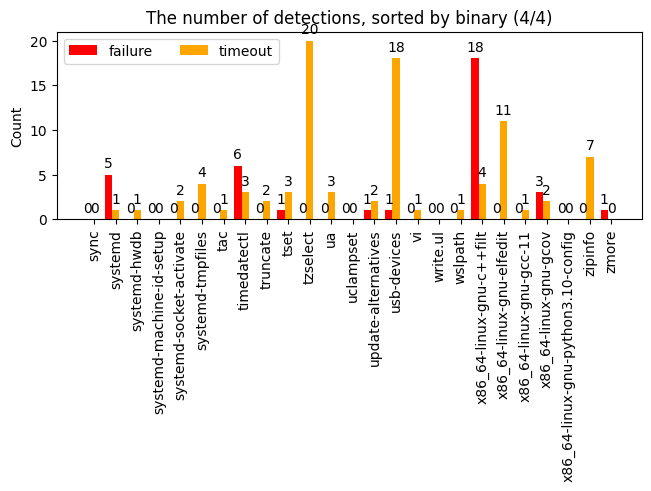

In [134]:
binary_only = df[['original', 'category']]
group_binary = binary_only.groupby(['original', 'category']).size()
binary_data = group_binary.unstack().reset_index().rename_axis(None, axis=1)
binary_data.fillna(0, inplace=True)

width = 0.2
multiplier = 0
headings = ['failure', 'timeout']
colours = {'failure': 'red', 'timeout': 'orange'}
xtick_pos = []
bin_names = []

fig, ax = plt.subplots(layout='constrained')
start = 75
count = 0
size = 25

for index, bin in binary_data.iterrows():
    if count < start:
        count += 1
        continue

    bin_names.append(bin.values[0])

    for head in headings:
        value = bin[head]
        value = 0 if math.isnan(value) else value

        offset = width * multiplier
        rects = ax.bar(offset, value, width, label=head, color=colours[head])
        ax.bar_label(rects, padding=3)
        multiplier += 1
        
    xtick_pos.append(width*(multiplier-1))
    multiplier += 1
    count += 1

    if count >= start + size:
        break


ax.set_ylabel("Count")
ax.set_title("The number of detections, sorted by binary (4/4)")
ax.set_xticks(xtick_pos, bin_names, rotation=90)
ax.legend(headings, loc='upper left', ncols=2)
plt.show()

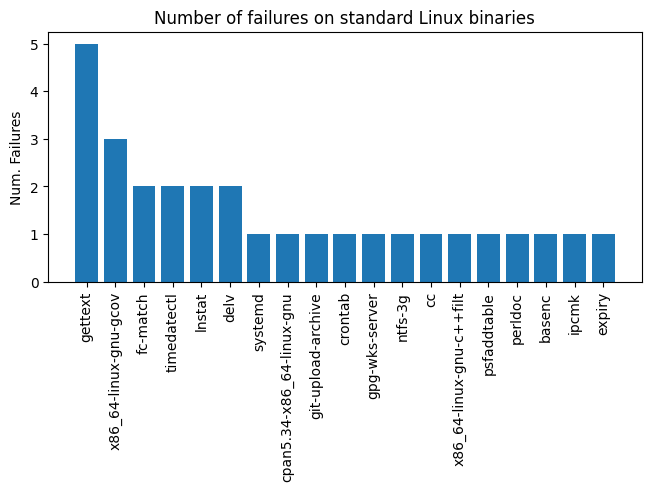

In [143]:
only_originals = df[df['file'].str.contains("_original")]
binary_orig_only = only_originals[['original', 'category']]
group_binary_orig_only = binary_orig_only.groupby(['original', 'category']).size()
binary_data_orig_only = group_binary_orig_only.unstack().reset_index().rename_axis(None, axis=1)
binary_data_orig_only.fillna(0, inplace=True)
binary_data_orig_only.sort_values('failure', inplace=True, ascending=False)

bin_names = []
failure_values = []

for index, bin in binary_data_orig_only.iterrows():
    if bin['failure'] > 0:
        bin_names.append(bin.values[0])
        failure_values.append(bin['failure'])


fig, ax = plt.subplots(layout='constrained')

ax.bar(bin_names, failure_values)
ax.set_title("Number of failures on standard Linux binaries")
ax.set_xticks(np.arange(len(bin_names)), bin_names, rotation=90)
ax.set_ylabel("Num. Failures")

plt.show()


In [145]:
binary_only = df[['original', 'category']]
group_binary = binary_only.groupby(['original', 'category']).size()
binary_data = group_binary.unstack().reset_index().rename_axis(None, axis=1)
binary_data.fillna(0, inplace=True)

for index, bin in binary_data.iterrows():
    if bin['failure'] == 0:
        print(bin.values[0])


apport-cli
ar
byobu-export
col
dbus-cleanup-sockets
dnsdomainname
dpkg-maintscript-helper
fc-cat
free
gcov-dump
gencat
gpgsplit
gunzip
hardlink
helpztags
journalctl
kbd_mode
locale
localedef
more
nano
nisdomainname
nsupdate
ntfsfallocate
prlimit
ptardiff
ptx
python3-config
rbash
rdx
rtstat
script
sdiff
sed
setmetamode
showkey
splain
sync
systemd-hwdb
systemd-machine-id-setup
systemd-socket-activate
systemd-tmpfiles
tac
truncate
tzselect
ua
uclampset
vi
write.ul
wslpath
x86_64-linux-gnu-elfedit
x86_64-linux-gnu-gcc-11
x86_64-linux-gnu-python3.10-config
zipinfo


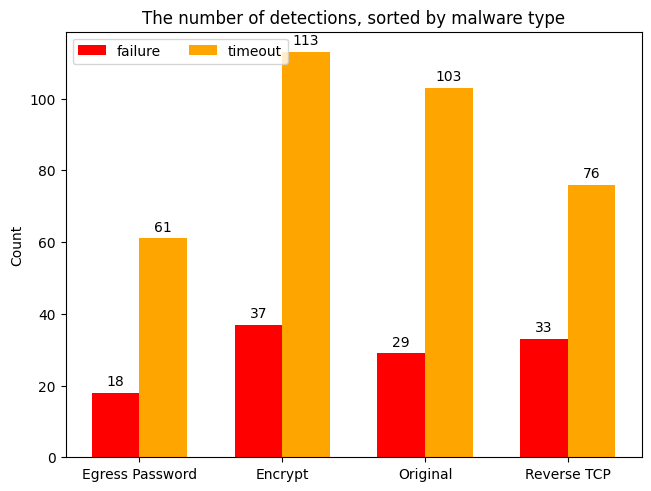

In [212]:
malware_types = add_malware_type(df)
malware_type_count = malware_types.groupby(['malware_type', 'category']).size()
malware_data = malware_type_count.unstack().reset_index().rename_axis(None, axis=1)

width = 0.2
multiplier = 0
headings = ['failure', 'timeout']
colours = {'failure': 'red', 'timeout': 'orange'}
xtick_pos = []
mal_types = []

fig, ax = plt.subplots(layout='constrained')


for index, mal_type in malware_data.iterrows():
    mal_types.append(mal_type.values[0])

    for head in headings:
        value = mal_type[head]

        offset = width * multiplier
        rects = ax.bar(offset, value, width, label=head, color=colours[head])
        ax.bar_label(rects, padding=3)
        multiplier += 1
        
    xtick_pos.append(width*(multiplier-1.5))
    multiplier += 1

ax.set_ylabel("Count")
ax.set_title("The number of detections, sorted by malware type")
ax.set_xticks(xtick_pos, mal_types,)
ax.legend(headings, loc='upper left', ncols=2)
plt.show()